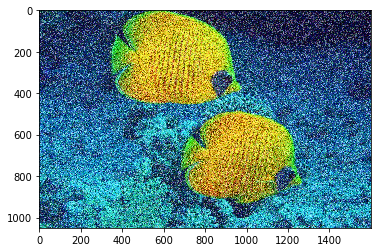

In [160]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread('data/fish.jpg', cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255.
img_rgb = img_rgb / 255.
plt.imshow(img_rgb)

# Main features

In [223]:
def slicer(img, dim):
    return img[:, :, dim]

def rm_noise(img):
    return cv2.GaussianBlur(img, ksize=(5, 5), sigmaX=15)

def mask(img, threshold):
    res = img.copy()
    res[img > threshold] = 1
    res[img <= threshold] = 0
    return res

def inverse(img):
    tmp = img.copy()
    if np.sum(img) > img.shape[0] * img.shape[1]:
        print('inverse')
        tmp = img.copy()
        tmp[img == 1] = 0
        tmp[img == 0] = 1
    return tmp

# Classify pixels: fish - not_fish

In [224]:
gauss = rm_noise(img)
vectorized = gauss.reshape((-1,3))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts = 15
ret,coord_0,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)

In [225]:
label = label.reshape((1050, 1600))
label = inverse(label)

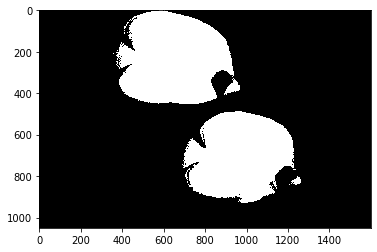

In [226]:
plt.imshow(label, cmap = 'gray')

# Clustering fishes in side the mask:
2 clusters doesn't give good results, so:
* make 3 clusters
* union 2 smallest

In [279]:
from sklearn.cluster import KMeans
def clustering_fishes(label):
    X = np.argwhere(label == 1)
    kmeans = KMeans(n_clusters=3, random_state=1).fit(X)
    Y = kmeans.predict(X)
    res = np.zeros(label.shape)
    for i, (x, y) in enumerate(zip(X, Y)):
        a, b = x[0], x[1]
        res[a, b] = y + 1
    return X, Y, res
X, Y, clustered_fishes_3 = clustering_fishes(label)

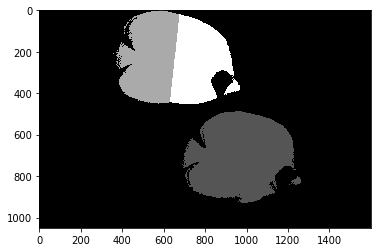

In [280]:
plt.imshow(clustered_fishes_3, cmap='gray')

In [281]:
from collections import Counter
def union_2_clusters(X, Y):
    counts = Counter(Y)
    print(counts)
    maximum = max(counts, key=counts.get)
    two_clusters = Y.copy()
    two_clusters[Y == maximum] = 0
    two_clusters[Y != maximum] = 1
    res_2 = np.zeros(label.shape)
    for i, (x, y) in enumerate(zip(X, two_clusters)):
        a, b = x[0], x[1]
        res_2[a, b] = y + 1
    return res_2, two_clusters
clustered_fishes_2, Y_2_cl = union_2_clusters(X, Y)

Counter({0: 174238, 1: 102690, 2: 93630})


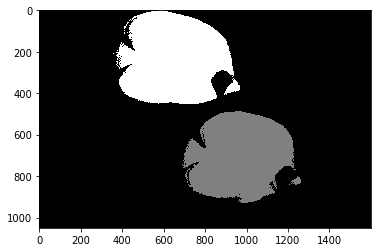

In [282]:
plt.imshow(clustered_fishes_2, cmap='gray')

# Get boundries of fishes

In [284]:
def get_bbox(X, Y, label):
    match = X[Y == label]
    max_0, max_1 = np.max(match, axis=0)
    min_0, min_1 = np.min(match, axis=0)
    bbox = [[max_0, max_1],[max_0, min_1], [min_0, min_1], [min_0, max_1]] 
    
    return bbox, {'r': max_0, 'u': max_1, 'le': min_0, 'lo': min_1}

In [285]:
def plot_bounded(img, b):
    plt.imshow(img[b['le']: b['r'] + 1, b['lo'] : b['u'] + 1], cmap='gray')

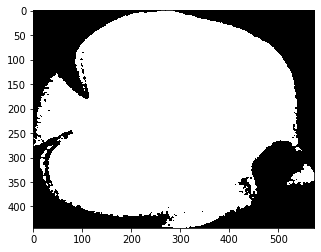

In [286]:
bbox_0, b_0 = get_bbox(X, Y_2_cl, 0)
plot_bounded(clustered_fishes_2, b_0)

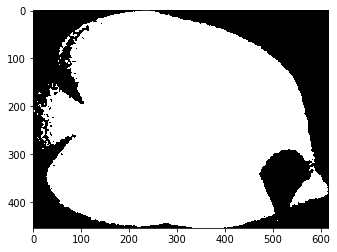

In [287]:
bbox_1, b_1 = get_bbox(X, Y_2_cl, 1)
plot_bounded(clustered_fishes_2, b_1)

# Detect the nose of the fish and find its length
assumptions: 
* fish is horisontally oriented 
* tail is the furthest point from the nose

Fish length is: 637.200910231616


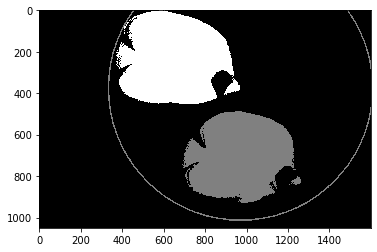

In [288]:
from scipy.spatial import distance_matrix

def get_orientation(img, b):
    tmp_img = img[b['le']: b['r'] + 1,b['lo']: b['u'] + 1]
    mid = int(tmp_img.shape[1] / 10)
    return 'left' if np.sum(tmp_img[:, -mid:]) > np.sum(tmp_img[:, :mid]) else 'right'

def fish_length(img, X, Y, label, b):
    tmp_img = img[b['le']: b['r'] + 1,b['lo']: b['u'] + 1]
    orientation = get_orientation(img, b)
    target = 0 if orientation == 'left' else -1
    coord_1 = b['le'] + np.mean(np.argwhere(tmp_img[:, target] > 0))
    coord_0 = b['lo'] if orientation == 'left' else b['u']
    return max(distance_matrix(X[Y == label], np.array([[coord_1, coord_0]])))[0], coord_0, coord_1

def plot_with_circle(image, radius, coord_0, coord_1):
    img = image.copy()
    img = cv2.circle(img, (int(coord_0), int(coord_1)), int(radius), (1, 1, 1), 6) 
    # Displaying the image  
    plt.imshow(img, cmap='gray')
radius_1, coord_0_1, coord_1_1 = fish_length(clustered_fishes_2, X, Y_2_cl, 1, b_1)
print(f'Fish length is: {radius_1}')
plot_with_circle(clustered_fishes_2, radius_1, coord_0_1, coord_1_1)

Fish length is: 580.1654936309121


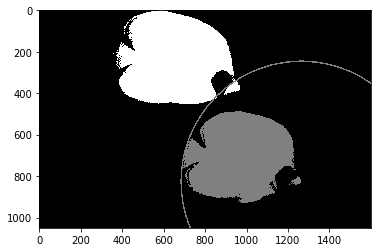

In [289]:
radius_0, coord_0_0, coord_1_0 = fish_length(clustered_fishes_2, X, Y_2_cl, 0, b_0)
print(f'Fish length is: {radius_0}')
plot_with_circle(clustered_fishes_2, radius_0, coord_0_0, coord_1_0)

**Lengths are found**

# Apply the mask so that the background is black

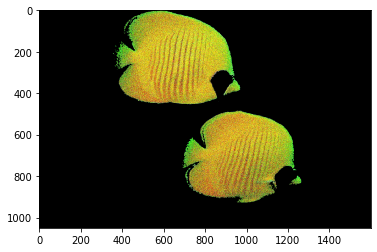

In [292]:
def plot_masked(img, mask):
    mask[mask > 0] = 1.
    mask_colored = np.zeros((mask.shape[0], mask.shape[1], 3))
    mask_colored[:, :, 0] = mask
    mask_colored[:, :, 1] = mask
    mask_colored[:, :, 2] = mask
    plt.imshow(rm_noise(img) * rm_noise(mask_colored))

plot_masked(img_rgb, clustered_fishes_2)

# Paint over the spot on the nose of the fish, knowing that it is inside the fish

{'r': 453, 'u': 971, 'le': 0, 'lo': 356}
971 759 241 453


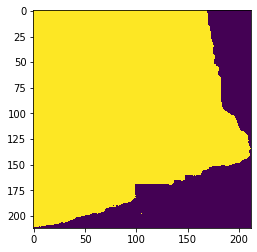

In [271]:
def paint_over(X, Y, b, radius, mask):
    new_mask = mask.copy()
    orientation = get_orientation(img, b)
    target = 0 if orientation == 'left' else -1
    rad = int(radius / 3)
    if orientation == 'right':
        lo = b['u'] - rad
        u = b['u']
    else:
        lo = b['u']
        u = b['u'] + rad
    r = b['r']
    le = b['r'] - rad
    print(b)
    print(u, lo, le, r)
    for i in range(le,r):
        for j in range(lo,u):
            if new_mask[i, j] == 0:
                if (np.sum(new_mask[i, lo:j]) > 4) and (np.sum(new_mask[i, j:u]) > 4):
                    new_mask[i,j] = 1
    for i in range(le,r):
        for j in range(lo,u):
            if new_mask[i, j] == 0:
                if (np.sum(new_mask[le:i, j]) > 4) and (np.sum(new_mask[i:r, j]) > 4):
                    new_mask[i,j] = 1 
    plt.imshow(new_mask[le:r, lo:u])
    return new_mask

new_mask = paint_over(X, Y_2_cl, b_1, radius_1, clustered_fishes_2)

{'r': 928, 'u': 1264, 'le': 485, 'lo': 691}
1264 1071 735 928


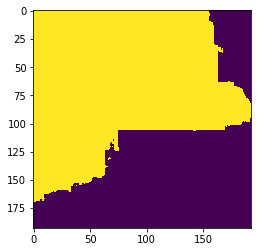

In [275]:
new_mask_next = paint_over(X, Y_2_cl, b_0, radius_0, new_mask)

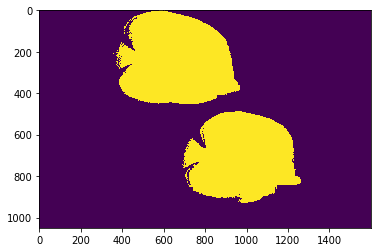

In [276]:
plt.imshow(new_mask_next)

# Final result

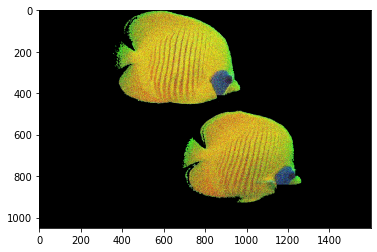

In [294]:
plot_masked(img_rgb, new_mask_next)